<a href="https://colab.research.google.com/github/aloy4646/CNN-for-Sentiment-Analysis-Using-Custom-Dataset/blob/main/Tugas_CNN_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis menggunakan CNN pada custom dataset

sumber referensi : https://www.kaggle.com/code/chibuzorokocha/airline-sentiment-analysis-90-accuracy-using-rnn/notebook dan tugas CNN sebelumnya dari buku

In [1]:
import re
import warnings
import itertools
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load dataset

In [3]:
tweets_df = pd.read_csv("drive/MyDrive/Twitter-US-Airline-Sentiment/Tweets.csv")
tweets = tweets_df.copy()

## Lihat isi dataset

In [4]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


fitur yang penting untuk sentiment analysis hanya airline_sentiment dan text. Text berisi kata-kata yang kurang penting seperti @VirginAmerica, @UnitedAir, dll yang merupakan Nama Akun dari airlines.

<Axes: >

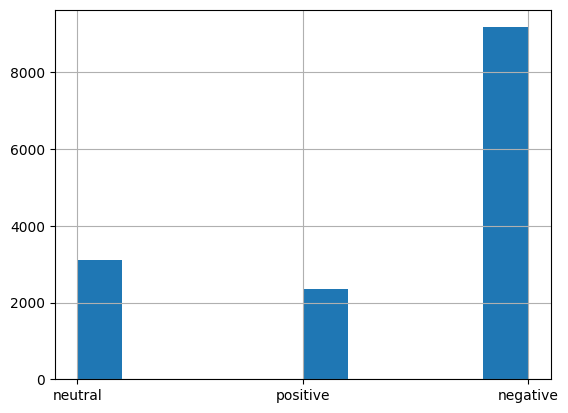

In [5]:
tweets['airline_sentiment'].hist()

Terjadi class imbalance, tweets ber-sentiment negative jauh lebih tinggi dibanding neutral maupun positive

## Data Cleaning

### Hapus nama akun airlines dari text

In [6]:
tweets_noAccountName = tweets[["text","airline_sentiment"]]
tweets_noAccountName['text'] = tweets_noAccountName['text'].map(lambda x: x.lstrip('@VirginAmerica@UnitedAir@Southwestairline@DeltaAir@USAirways@American').rstrip('@'))

<ipython-input-6-cc87d9ec078b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_noAccountName['text'] = tweets_noAccountName['text'].map(lambda x: x.lstrip('@VirginAmerica@UnitedAir@Southwestairline@DeltaAir@USAirways@American').rstrip('@'))


In [7]:
tweets_noAccountName.head()

,text,airline_sentiment
0,What @dhepburn said.,neutral
1,plus you've added commercials to the experien...,positive
2,I didn't today... Must mean I need to take an...,neutral
3,"it's really aggressive to blast obnoxious ""en...",negative
4,and it's a really big bad thing about it,negative


### Menghapus neutral sentiment. Sentiment yang akan dipakai hanya positive dan negative

In [8]:
tweets_noNeutral = tweets_noAccountName[tweets_noAccountName.airline_sentiment!="neutral"]

<Axes: >

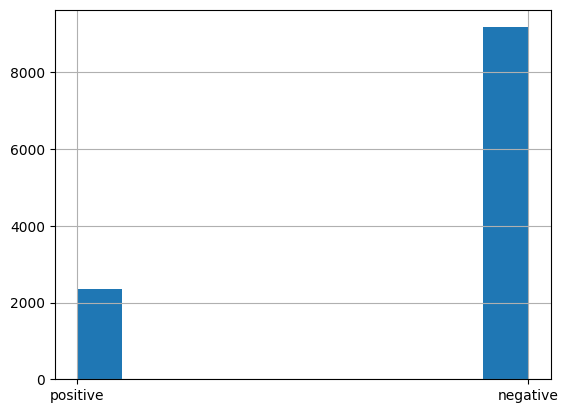

In [9]:
tweets_noNeutral['airline_sentiment'].hist()

### Menghapus beberapa tweets yang ber-sentiment negative agar seimbang dengan positive

In [10]:
jumlah_negative_yang_dihapus = len(tweets_noNeutral[tweets_noNeutral['airline_sentiment']=='negative']) - len(tweets_noNeutral[tweets_noNeutral['airline_sentiment']=='positive'])
tweets_balance = tweets_noNeutral.drop(tweets_noNeutral[tweets_noNeutral.airline_sentiment == "negative"].iloc[:jumlah_negative_yang_dihapus].index)
print('Sebanyak %s tweets yang ber-sentiment negative telah dihapus' % jumlah_negative_yang_dihapus)

Sebanyak 6815 tweets yang ber-sentiment negative telah dihapus


<Axes: >

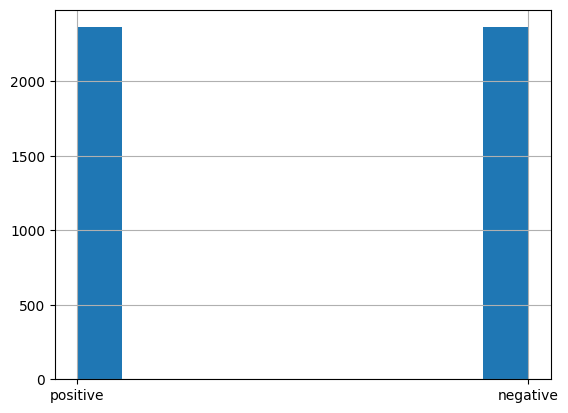

In [11]:
tweets_balance['airline_sentiment'].hist()

### Menghapus huruf-huruf unik dan membuat text menjadi lower case

In [12]:
tweets_clean = tweets_balance
tweets_clean['text'] = tweets_clean['text'].apply(lambda x: x.lower())
tweets_clean['text'] = tweets_clean['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) # hanya menyimipan angka dan string saja
tweets_clean

,text,airline_sentiment
1,plus youve added commercials to the experienc...,positive
6,yes nearly every time i fly vx this ear worm ...,positive
8,virginamerica well i didntbut now i do d,positive
9,it was amazing and arrived an hour early your...,positive
11,i lt3 pretty graphics so much better than min...,positive
...,...,...
14633,my flight was cancelled flightled leaving tom...,negative
14634,right on cue with the delays,negative
14635,thank you we got on a different flight to chi...,positive
14636,leaving over 20 minutes late flight no warnin...,negative


## Mengubah text ke sequence of integers / Tokenizing

In [13]:
max_fatures = 4000
tokenizer = Tokenizer(num_words = max_fatures, split=' ')
tokenizer.fit_on_texts(tweets_clean['text'].values)
X = tokenizer.texts_to_sequences(tweets_clean['text'].values)
X = pad_sequences(X)
Y = tweets_clean['airline_sentiment']
L = Y.values

# X ==> text yang sudah diubah menjadi integer yang unik dan merepresentasikan sebuah kata
# L ==> airlines_sentiment yang di-convert ke Numpy Array agar bisa digunakan sebagai label saat di-training

In [14]:
X

array([[   0,    0,    0, ...,    2,  194, 3201],
       [   0,    0,    0, ...,  220,  138,  421],
       [   0,    0,    0, ...,    3,   46,  757],
       ...,
       [   0,    0,    0, ...,    8,    1,  438],
       [   0,    0,    0, ..., 1389,   42,  805],
       [   0,    0,    0, ...,  135,   10, 1592]], dtype=int32)

In [15]:
L

array(['positive', 'positive', 'positive', ..., 'positive', 'negative',
       'negative'], dtype=object)

### mengubah L (label) menjadi integer

In [16]:
label = []
for i in range(len(L)):
    if L[i]=="negative":
                        label.append(0)
    elif L[i]=="positive":
                        label.append(1)
label = np.array(label)

## Split train dan test data

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, label, 
                                                    test_size=0.3, 
                                                    shuffle = True,
                                                    stratify = label,
                                                    random_state = 1)

## Membuat model untuk training

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 31, 100)           400000    
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 32)            25632     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 12, 32)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 384)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                3850      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                      

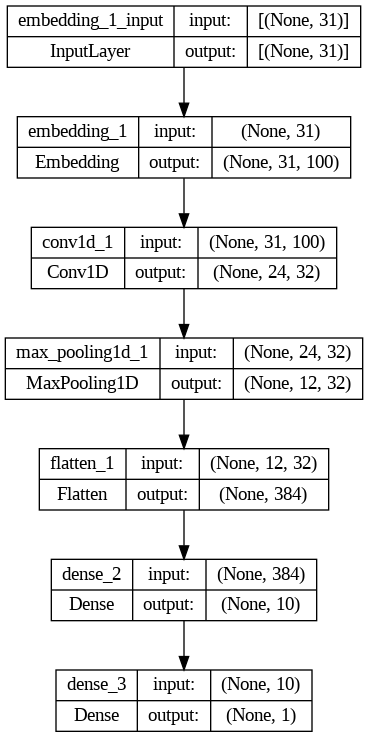

In [21]:
model = Sequential()
model.add(Embedding(max_fatures, 100, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
plot_model(model, to_file='drive/MyDrive/Twitter-US-Airline-Sentiment/model.png', show_shapes=True)

In [22]:
Model = model.fit(X_train,
                  Y_train,
                  epochs=20,
                  batch_size=32,
                  validation_split = 0.2,
                  verbose = 2)

Epoch 1/20
83/83 - 9s - loss: 0.5552 - accuracy: 0.7203 - val_loss: 0.3581 - val_accuracy: 0.8550 - 9s/epoch - 109ms/step
Epoch 2/20
83/83 - 4s - loss: 0.2321 - accuracy: 0.9116 - val_loss: 0.2711 - val_accuracy: 0.9003 - 4s/epoch - 48ms/step
Epoch 3/20
83/83 - 2s - loss: 0.0975 - accuracy: 0.9675 - val_loss: 0.2760 - val_accuracy: 0.9003 - 2s/epoch - 18ms/step
Epoch 4/20
83/83 - 2s - loss: 0.0418 - accuracy: 0.9890 - val_loss: 0.3233 - val_accuracy: 0.8912 - 2s/epoch - 26ms/step
Epoch 5/20
83/83 - 1s - loss: 0.0188 - accuracy: 0.9951 - val_loss: 0.3398 - val_accuracy: 0.8912 - 937ms/epoch - 11ms/step
Epoch 6/20
83/83 - 1s - loss: 0.0109 - accuracy: 0.9974 - val_loss: 0.3742 - val_accuracy: 0.8943 - 1s/epoch - 13ms/step
Epoch 7/20
83/83 - 1s - loss: 0.0089 - accuracy: 0.9977 - val_loss: 0.3948 - val_accuracy: 0.8852 - 911ms/epoch - 11ms/step
Epoch 8/20
83/83 - 1s - loss: 0.0083 - accuracy: 0.9981 - val_loss: 0.3971 - val_accuracy: 0.8927 - 926ms/epoch - 11ms/step
Epoch 9/20
83/83 - 1s 

## Evaluasi

In [26]:
hasil_evaluasi = model.evaluate(X_test, Y_test, verbose=False)
print("loss = ",hasil_evaluasi[0])
print("accuracy = ",hasil_evaluasi[1])

loss =  0.5314568877220154
accuracy =  0.8843441605567932


45/45 [==============================] - 0s 2ms/step


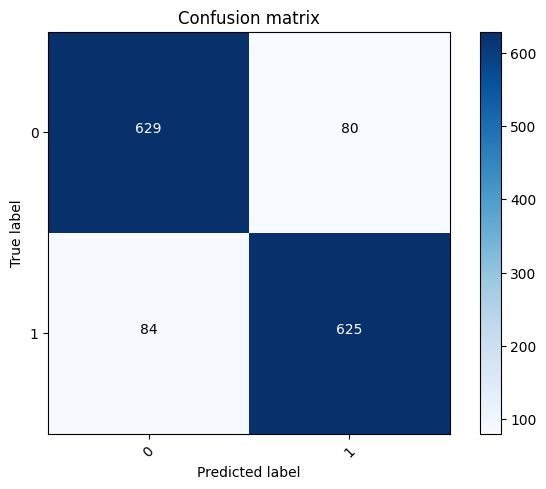

In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = model.predict(X_test)
threshold = 0.5
y_pred_classes = (y_pred > threshold).astype(int)
confusion_mtx = confusion_matrix(Y_test, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(2)) 

## Test

In [39]:
kalimat = ['Meetings: Air crew is so dumb.']
# sample = ['it was amazing and arrived an hour early']
kalimat = tokenizer.texts_to_sequences(kalimat)
kalimat = pad_sequences(kalimat, maxlen=31, dtype='int32', value=0)
sentiment_prediksi = model.predict(kalimat,batch_size=1,verbose = 2)[0]

if(sentiment_prediksi[0] < 0.5):
    print("negative")
else:
    print("positive")

1/1 - 0s - 24ms/epoch - 24ms/step
negative


In [40]:
kalimat = ['it was amazing and arrived an hour early']
kalimat = tokenizer.texts_to_sequences(kalimat)
kalimat = pad_sequences(kalimat, maxlen=31, dtype='int32', value=0)
sentiment_prediksi = model.predict(kalimat,batch_size=1,verbose = 2)[0]

if(sentiment_prediksi[0] < 0.5):
    print("negative")
else:
    print("positive")

1/1 - 0s - 37ms/epoch - 37ms/step
positive
